# observing-hares
notebook for simulating observation(s) of hares drawn using `drawing-hares.ipynb`

In [25]:
# stock imports
import numpy as np
import pandas as pd
import json
import scipy
import os
import random

##plotting
import matplotlib.pyplot as plt

# plt.style.use('dark_background')
plt.style.use("default")

## single hare
let's try to get this working for a single hare first, with fairly uninformed observational uncertainties

In [2]:
hare_idx = 42
hare_df = pd.read_json(f"form/hare{hare_idx}/hare{hare_idx}.json")
hare_df

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,star_feh,nu_0_6,nu_0_7,...,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,calc_effective_T,nu_max_n
1762182,0.88,0.010769,0.24,2.5,4.93214,0.810089,0.522261,-0.141454,1248.658002,1437.778516,...,6013.993977,6189.616744,6365.051666,6539.03642,6706.181669,6876.731218,7044.334608,7208.437697,5451.702676,23


[ 5.54310876e+03  6.05188362e-01 -1.63215223e-01  2.83064550e+03
  2.99110804e+03  3.15140212e+03  3.31246333e+03  3.47411880e+03
  3.63561296e+03  3.79764629e+03  3.95991856e+03  4.12243735e+03
  4.28570720e+03  4.44901900e+03  4.61266467e+03  4.77665354e+03]
[ 5.52792131e+03  5.82591549e-01 -2.37025148e-01  2.83414157e+03
  2.99125318e+03  3.15182426e+03  3.31240105e+03  3.47378763e+03
  3.63608208e+03  3.79768905e+03  3.96040270e+03  4.12208137e+03
  4.28573054e+03  4.44868330e+03  4.61388277e+03  4.77714651e+03]


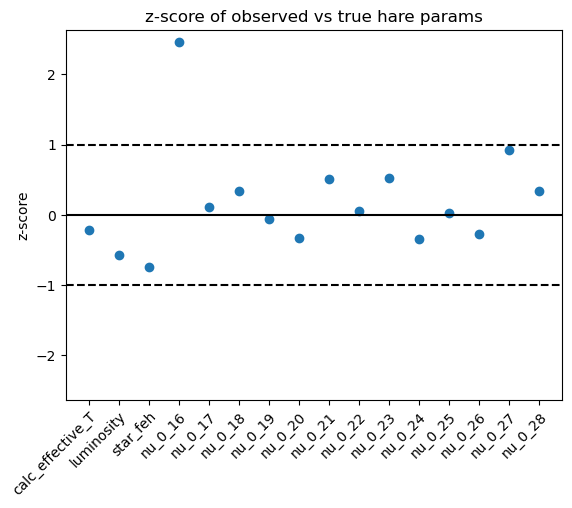

In [35]:
def nu_max_range(nu_max_n, mode_min=8, mode_max=13):
    modes = np.random.randint(mode_min, mode_max)
    flip = np.random.randint(2)
    int_half = int(modes * 0.5)
    if flip:
        n_min = nu_max_n - int_half
        n_max = nu_max_n + (modes - int_half)
    else:
        n_min = nu_max_n - (modes - int_half)
        n_max = nu_max_n + int_half

    return n_min, n_max


def obs_noise(true, unc, seed=None):
    seeded_random_state = np.random.RandomState(seed=seed)
    rvs_random_states = seeded_random_state.randint(0, high=2**32 - 1, size=len(true))
    noisy_obs = np.empty(len(true))
    idx = 0
    for ob in true:
        noisy_obs[idx] = scipy.stats.norm(loc=ob, scale=unc[idx]).rvs(
            random_state=rvs_random_states[idx]
        )
        idx += 1

    return noisy_obs


nu_max_n = hare_df["nu_max_n"].values[0]
n_min, n_max = nu_max_range(nu_max_n)

inputs = ["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT", "star_age"]
outputs = ["calc_effective_T", "luminosity", "star_feh"] + [
    f"nu_0_{i}" for i in range(n_min, n_max + 1)
]

hare_cut = hare_df[inputs + outputs]

teff_unc = 70  # K
luminosity_unc = 0.04  # L\odot
surface_feh_unc = 0.1  # dex
frequency_unc = np.random.uniform(0.1, 1)  # \muHz

obs_unc = np.array(
    [teff_unc, luminosity_unc, surface_feh_unc]
    + [frequency_unc + abs(i - nu_max_n) * 0.1 for i in range(n_min, n_max + 1)]
)

hare_obs = obs_noise(hare_cut.drop(inputs, axis=1).values[0], obs_unc)

print(hare_cut[outputs].values[0])
print(hare_obs)

fig, ax = plt.subplots()
ax.scatter(
    np.arange(0, len(obs_unc)), (hare_obs - hare_cut[outputs].values[0]) / obs_unc
)
ax.axhline(0, c="black")
ax.axhline(-1, c="black", linestyle="--")
ax.axhline(1, c="black", linestyle="--")

yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
ax.set_xticks(np.arange(0, len(obs_unc)))
ax.set_xticklabels(outputs)
# ax.tick_params(axis='x', labelrotation=90)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title("z-score of observed vs true hare params")
ax.set_ylabel("z-score")
plt.savefig(f"form/hare{hare_idx}/obs0/true_vs_obs.png", bbox_inches="tight")

## all hares in form

In [7]:
def nu_max_range(nu_max_n, mode_min=8, mode_max=13):
    modes = np.random.randint(mode_min, mode_max)
    flip = np.random.randint(2)
    int_half = int(modes * 0.5)
    if flip:
        n_min = nu_max_n - int_half
        n_max = nu_max_n + (modes - int_half)
    else:
        n_min = nu_max_n - (modes - int_half)
        n_max = nu_max_n + int_half

    return n_min, n_max


def obs_noise(true, unc, seed=None):
    seeded_random_state = np.random.RandomState(seed=seed)
    rvs_random_states = seeded_random_state.randint(0, high=2**32 - 1, size=len(true))
    noisy_obs = np.empty(len(true))
    idx = 0
    for ob in true:
        noisy_obs[idx] = scipy.stats.norm(loc=ob, scale=unc[idx]).rvs(
            random_state=rvs_random_states[idx]
        )
        idx += 1

    return noisy_obs


inputs = ["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT", "star_age"]

teff_unc = 70  # K
luminosity_unc = 0.04  # L\odot
surface_feh_unc = 0.1  # dex

obs_idx = 0
for hare_idx in range(100):
    hare_df = pd.read_json(f"form/hare{hare_idx}/hare{hare_idx}.json")

    nu_max_n = hare_df["nu_max_n"].values[0]
    n_min, n_max = nu_max_range(nu_max_n)
    outputs = ["calc_effective_T", "luminosity", "star_feh"] + [
        f"nu_0_{i}" for i in range(n_min, n_max + 1)
    ]

    hare_cut = hare_df[inputs + outputs]

    frequency_unc = np.random.uniform(0.1, 1)  # \muHz

    obs_unc = np.array(
        [teff_unc, luminosity_unc, surface_feh_unc]
        + [frequency_unc + abs(i - nu_max_n) * 0.1 for i in range(n_min, n_max + 1)]
    )

    hare_obs = obs_noise(hare_cut.drop(inputs, axis=1).values[0], obs_unc)

    hare_obs = obs_noise(hare_cut[outputs].values[0], obs_unc)
    hare_obs_df = hare_cut.copy()
    hare_obs_df[outputs] = hare_obs

    fig, ax = plt.subplots()
    ax.scatter(
        np.arange(0, len(obs_unc)), (hare_obs - hare_cut[outputs].values[0]) / obs_unc
    )
    ax.axhline(0, c="black")
    ax.axhline(-1, c="black", linestyle="--")
    ax.axhline(1, c="black", linestyle="--")

    yabs_max = abs(max(ax.get_ylim(), key=abs))
    ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
    ax.set_xticks(np.arange(0, len(obs_unc)))
    ax.set_xticklabels(outputs)
    # ax.tick_params(axis='x', labelrotation=90)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_title("z-score of observed vs true hare params")
    ax.set_ylabel("z-score")

    path = f"form/hare{hare_idx}/obs{obs_idx}"
    if not os.path.exists(path):
        os.mkdir(path)
        print(f"{path} created!")
    else:
        print(f"{path} already exists", end="\r")
    hare_obs_df.to_json(path + f"/obs{obs_idx}.json")
    pd.DataFrame([obs_unc], columns=outputs).to_json(path + "/uncs.json")
    plt.savefig(path + "/zscore_plot.png", bbox_inches="tight")
    plt.close()

## repeating to include surface term

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

/tmp/ipykernel_22530/3634160853.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hare_cut.loc[:,[f'nu_0_{i}' for i in range(n_min, n_max+1)]] = freqs_corr
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


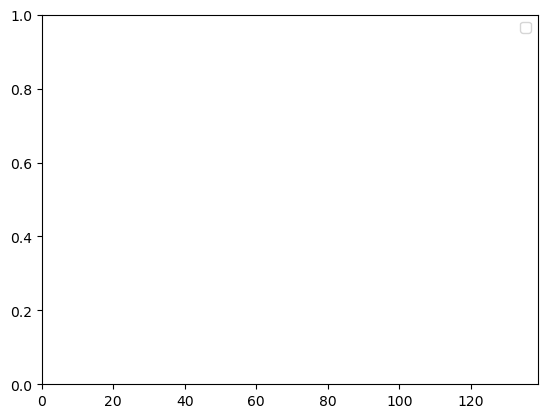

In [160]:
def nu_max_range(nu_max_n, mode_min=8, mode_max=13):
    modes = np.random.randint(mode_min, mode_max)
    flip = np.random.randint(2)
    int_half = int(modes * 0.5)
    if flip:
        n_min = nu_max_n - int_half
        n_max = nu_max_n + (modes - int_half)
    else:
        n_min = nu_max_n - (modes - int_half)
        n_max = nu_max_n + int_half

    return n_min, n_max


def obs_noise(true, unc, seed=None):
    seeded_random_state = np.random.RandomState(seed=seed)
    rvs_random_states = seeded_random_state.randint(0, high=2**32 - 1, size=len(true))
    noisy_obs = np.empty(len(true))
    idx = 0
    for ob in true:
        noisy_obs[idx] = scipy.stats.norm(loc=ob, scale=unc[idx]).rvs(
            random_state=rvs_random_states[idx]
        )
        idx += 1

    return noisy_obs


def surf_corr(freqs, nu_max, a, b):
    return freqs + a * ((freqs / nu_max) ** b)


inputs = ["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT", "star_age"]

teff_unc = 70  # K
luminosity_unc = 0.04  # L\odot
surface_feh_unc = 0.1  # dex

obs_idx = 0
for hare_idx in range(100):
    hare_df = pd.read_json(f"surf_form/hare{hare_idx}/hare{hare_idx}.json")

    nu_max_n = hare_df["nu_max_n"].values[0]
    n_min, n_max = nu_max_range(nu_max_n)
    outputs = ["calc_effective_T", "luminosity", "star_feh"] + [
        f"nu_0_{i}" for i in range(n_min, n_max + 1)
    ]

    hare_cut = hare_df[inputs + outputs]

    ### add surface correction
    # generate a and b
    a = random.uniform(-10, 2)
    b = random.uniform(4.4, 5.25)

    freqs = hare_cut[[f"nu_0_{i}" for i in range(n_min, n_max + 1)]].values[0]

    dnu = np.mean(freqs[1:] - freqs[:-1])

    nu_max = freqs.mean()
    # shift frequencies
    freqs_corr = surf_corr(freqs, nu_max, a, b)

    # reapply

    hare_cut.loc[:, [f"nu_0_{i}" for i in range(n_min, n_max + 1)]] = freqs_corr

    frequency_unc = np.random.uniform(0.1, 1)  # \muHz

    obs_unc = np.array(
        [teff_unc, luminosity_unc, surface_feh_unc]
        + [frequency_unc + abs(i - nu_max_n) * 0.1 for i in range(n_min, n_max + 1)]
    )

    hare_obs = obs_noise(hare_cut.drop(inputs, axis=1).values[0], obs_unc)

    hare_obs = obs_noise(hare_cut[outputs].values[0], obs_unc)
    hare_obs_df = hare_cut.copy()
    hare_obs_df[outputs] = hare_obs
    hare_obs_df[["a", "b"]] = [a, b]

    # plt.scatter(hare_obs_df[[f'nu_0_{i}' for i in range(n_min, n_max+1)]]%dnu, hare_obs_df[[f'nu_0_{i}' for i in range(n_min, n_max+1)]], label=f'a={a:.2f}, b={b:.2f}, obs unc')

    plt.xlim((0, dnu))
    plt.legend()
    fig, ax = plt.subplots()
    ax.scatter(
        np.arange(0, len(obs_unc)), (hare_obs - hare_cut[outputs].values[0]) / obs_unc
    )
    ax.axhline(0, c="black")
    ax.axhline(-1, c="black", linestyle="--")
    ax.axhline(1, c="black", linestyle="--")

    yabs_max = abs(max(ax.get_ylim(), key=abs))
    ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
    ax.set_xticks(np.arange(0, len(obs_unc)))
    ax.set_xticklabels(outputs)
    # ax.tick_params(axis='x', labelrotation=90)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_title("z-score of observed vs true hare params")
    ax.set_ylabel("z-score")

    path = f"surf_form/hare{hare_idx}/obs{obs_idx}"
    if not os.path.exists(path):
        os.mkdir(path)
        print(f"{path} created!")
    else:
        print(f"{path} already exists", end="\r")
    hare_obs_df.to_json(path + f"/obs{obs_idx}.json")
    pd.DataFrame([obs_unc], columns=outputs).to_json(path + "/uncs.json")
    plt.savefig(path + "/zscore_plot.png", bbox_inches="tight")
    plt.close()